In [3]:
# Importando bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para regressão logística
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Lendo o arquivo
df = pd.read_csv('/content/titanic_tratado_final.csv')

# Mostrando as 5 primeiras linhas
df.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",NaN,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",NaN,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",NaN,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",NaN,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",NaN,35.0,0,0,373450,8.0500,NaN,S


In [30]:
import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ===========================
# 1) Inspeção rápida da coluna Sex
# ===========================
print("Sex unique values (sample):", df['Sex'].unique()[:20])
print(df['Sex'].isnull().sum(), "nulos em Sex")

# ===========================
# 2) Extrair Title do Name
# ===========================
def extract_title(name):
    m = re.search(r',\s*([^.]*)\.', name)
    if m:
        return m.group(1).strip()
    return "Unknown"

df['Title'] = df['Name'].apply(extract_title)

# Mapear títulos raros
title_map = {
    'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master',
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'
}
df['Title'] = df['Title'].map(lambda t: title_map.get(t, 'Rare'))

# ===========================
# 3) Reconstruir Sex a partir do Title
# ===========================
if df['Sex'].isnull().all():
    print("Reconstruindo Sex a partir do Title (Sex estava todo NaN)...")
    def title_to_sex(title):
        if title in ['Mr', 'Master']:
            return 'male'
        if title in ['Mrs', 'Miss']:
            return 'female'
        return 'male'  # fallback
    df['Sex'] = df['Title'].apply(title_to_sex)

# Imputar Sex se houver alguns NaNs
if df['Sex'].isnull().any():
    df['Sex'] = df['Sex'].fillna(df['Title'].map(lambda t: 'male' if t in ['Mr', 'Master'] else 'female'))

# ===========================
# 4) Tratar Embarked
# ===========================
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# ===========================
# 5) Tratar Cabin: extrair deck
# ===========================
def cabin_to_deck(c):
    if pd.isnull(c):
        return 'U'
    return str(c)[0].upper()

df['CabinDeck'] = df['Cabin'].apply(cabin_to_deck)

# ===========================
# 6) Imputar Age
# ===========================
age_median_by_title = df.groupby('Title')['Age'].median()
df['Age'] = df.apply(lambda row: age_median_by_title[row['Title']] if pd.isnull(row['Age']) else row['Age'], axis=1)
df['Age'] = df['Age'].fillna(df['Age'].median())  # fallback mediana global

# ===========================
# 7) Transformar Fare
# ===========================
df['Fare_log'] = np.log1p(df['Fare'])

# ===========================
# 8) Selecionar features e target
# ===========================
X = df[['Pclass','Sex','Age','SibSp','Parch','Fare_log','Embarked','Title','CabinDeck']].copy()
y = df['Survived']

# ===========================
# 9) Encoding categóricas
# ===========================
X = pd.get_dummies(X, columns=['Sex','Embarked','Title','CabinDeck','Pclass'], drop_first=True)

# ===========================
# 10) Escalar variáveis numéricas
# ===========================
scaler = StandardScaler()
X[['Age','Fare_log']] = scaler.fit_transform(X[['Age','Fare_log']])

# ===========================
# 11) Divisão treino/teste
# ===========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Pré-processamento concluído. Shape X_train:", X_train.shape, "X_test:", X_test.shape)


Sex unique values (sample): ['male' 'female']
0 nulos em Sex
Pré-processamento concluído. Shape X_train: (712, 21) X_test: (179, 21)


In [31]:
# Informações gerais do dataset
df.info()

# Estatísticas descritivas
df.describe()

# Verificando se há valores nulos
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Title        891 non-null    object 
 13  CabinDeck    891 non-null    object 
 14  Fare_log     891 non-null    float64
dtypes: float64(3), int64(5), object(7)
memory usage: 104.5+ KB


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


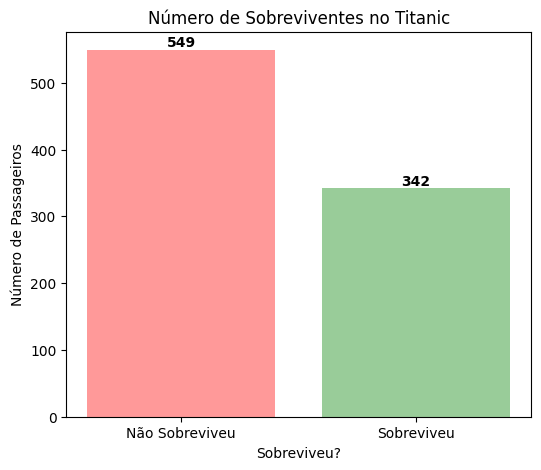

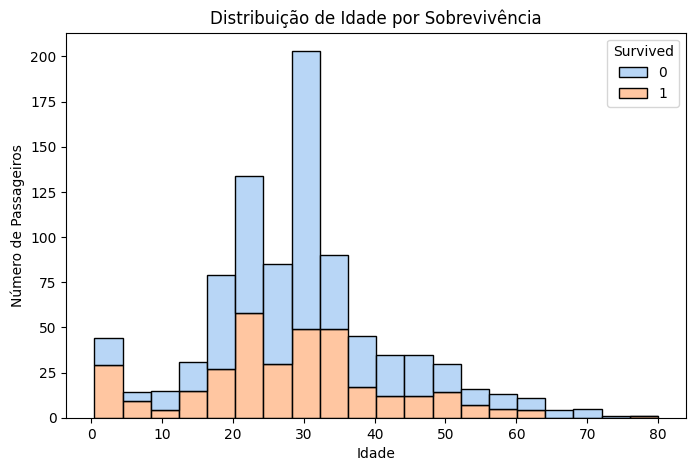

In [32]:
import matplotlib.pyplot as plt

# Contagem de sobreviventes
survived_counts = df['Survived'].value_counts()
labels = ['Não Sobreviveu', 'Sobreviveu']
colors = ['#FF9999', '#99CC99']

# Gráfico de barras com matplotlib
plt.figure(figsize=(6,5))
bars = plt.bar(labels, survived_counts.values, color=colors)

# Título e rótulos
plt.title('Número de Sobreviventes no Titanic')
plt.ylabel('Número de Passageiros')
plt.xlabel('Sobreviveu?')

# Adicionando valores acima das barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, str(int(height)), ha='center', fontweight='bold')

plt.show()

plt.figure(figsize=(8,5))
sns.histplot(data=df, x='Age', hue='Survived', multiple='stack', bins=20, palette='pastel')
plt.title('Distribuição de Idade por Sobrevivência')
plt.xlabel('Idade')
plt.ylabel('Número de Passageiros')
plt.show()






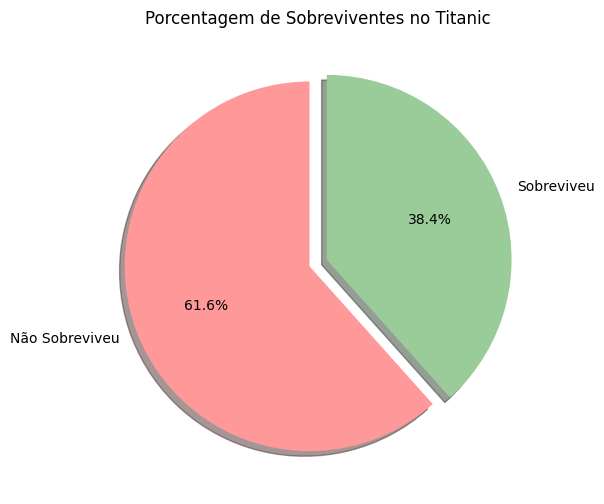

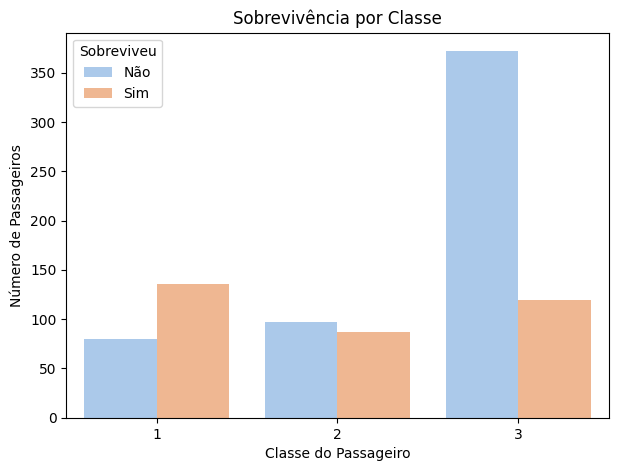

In [8]:
import matplotlib.pyplot as plt

# Contagem de sobreviventes
survived_counts = df['Survived'].value_counts()
labels = ['Não Sobreviveu', 'Sobreviveu']
colors = ['#FF9999', '#99CC99']  # cores agradáveis

# Criando o gráfico de pizza
plt.figure(figsize=(6,6))
plt.pie(
    survived_counts,
    labels=labels,
    autopct='%1.1f%%',  # mostra porcentagem com 1 casa decimal
    startangle=90,       # começa o gráfico de cima
    colors=colors,
    explode=(0.05, 0.05),  # destaca ligeiramente as fatias
    shadow=True
)
plt.title('Porcentagem de Sobreviventes no Titanic')
plt.show()

plt.figure(figsize=(7,5))
sns.countplot(x='Pclass', hue='Survived', data=df, palette='pastel')
plt.title('Sobrevivência por Classe')
plt.xlabel('Classe do Passageiro')
plt.ylabel('Número de Passageiros')
plt.legend(title='Sobreviveu', labels=['Não', 'Sim'])
plt.show()


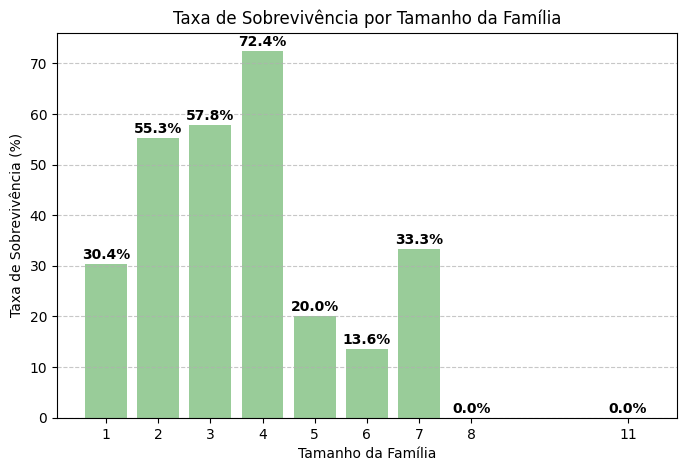

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Criando coluna FamilySize
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Calculando taxa de sobrevivência por tamanho de família
family_survival_rate = df.groupby('FamilySize')['Survived'].mean() * 100  # em %

# Transformando em DataFrame
family_df = family_survival_rate.reset_index().rename(columns={'Survived':'SurvivalRate'})

# Gráfico de barras
plt.figure(figsize=(8,5))
bars = plt.bar(family_df['FamilySize'], family_df['SurvivalRate'], color='#99CC99')

plt.title('Taxa de Sobrevivência por Tamanho da Família')
plt.xlabel('Tamanho da Família')
plt.ylabel('Taxa de Sobrevivência (%)')
plt.xticks(family_df['FamilySize'])  # garante que todos os tamanhos apareçam

# Adicionando valores acima das barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


PRÉ-PROCESSAMENTO DOS DADOS

In [15]:
# --------------------------
# PRÉ-PROCESSAMENTO SEGURO
# --------------------------
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler

# Carregar dataset
df = pd.read_csv('/content/titanic_tratado_final.csv')

# 1) Extrair Title do Name
def extract_title(name):
    m = re.search(r',\s*([^.]*)\.', name)
    return m.group(1).strip() if m else "Unknown"

df['Title'] = df['Name'].apply(extract_title)
title_map = {'Mr':'Mr','Mrs':'Mrs','Miss':'Miss','Master':'Master',
             'Mlle':'Miss','Ms':'Miss','Mme':'Mrs'}
df['Title'] = df['Title'].map(lambda t: title_map.get(t,'Rare'))

# 2) Extrair Deck da cabine
def cabin_to_deck(c):
    return str(c)[0].upper() if pd.notnull(c) else 'U'

df['CabinDeck'] = df['Cabin'].apply(cabin_to_deck)

# 3) Imputar Age por Title
age_median_by_title = df.groupby('Title')['Age'].median()
df['Age'] = df.apply(lambda row: age_median_by_title[row['Title']]
                     if pd.isnull(row['Age']) else row['Age'], axis=1)

# 4) Fallback global para Age (caso ainda haja nulos)
df['Age'] = df['Age'].fillna(df['Age'].median())

# 5) Imputar Embarked com moda
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# 6) Garantir que Sex seja tipo object e imputar via Title se houver nulos
df['Sex'] = df['Sex'].astype(object)
if df['Sex'].isnull().any():
    df.loc[df['Sex'].isnull(), 'Sex'] = df.loc[df['Sex'].isnull(), 'Title'].map(
        lambda t: 'male' if t in ['Mr','Master'] else 'female'
    )

# 7) Transformar Fare (log)
df['Fare_log'] = np.log1p(df['Fare'])

# 8) Selecionar features e target
features = ['Pclass','Sex','Age','SibSp','Parch','Fare_log','Embarked','Title','CabinDeck']
X = df[features].copy()
y = df['Survived']

# 9) Encoding categóricas
X = pd.get_dummies(X, columns=['Sex','Embarked','Title','CabinDeck','Pclass'], drop_first=True)

# 10) Escalonamento numérico
scaler = StandardScaler()
X.loc[:, ['Age','Fare_log']] = scaler.fit_transform(X[['Age','Fare_log']])

print("Pré-processamento seguro concluído. Shape X:", X.shape)


Pré-processamento seguro concluído. Shape X: (891, 21)


DIVISÃO EM TREINO E TESTE + TREINAMENTO

In [16]:
# --------------------------
# DIVISÃO TREINO/TESTE + TREINAMENTO
# --------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Divisão treino/teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Treinar modelo de regressão logística
model = LogisticRegression(max_iter=5000, solver='liblinear')
model.fit(X_train, y_train)

print("Treinamento concluído. Shape X_train:", X_train.shape, "X_test:", X_test.shape)


Treinamento concluído. Shape X_train: (712, 21) X_test: (179, 21)


AVALIAÇÃO DO MODELO

In [18]:
# --------------------------
# AVALIAÇÃO DO MODELO
# --------------------------
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Previsões
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

# Relatório de classificação
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC AUC:", roc_auc)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:\n", cm)


Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87       110
           1       0.81      0.75      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179

ROC AUC: 0.8608695652173913
Matriz de Confusão:
 [[98 12]
 [17 52]]


GRÁFICOS DE AVALIAÇÃO


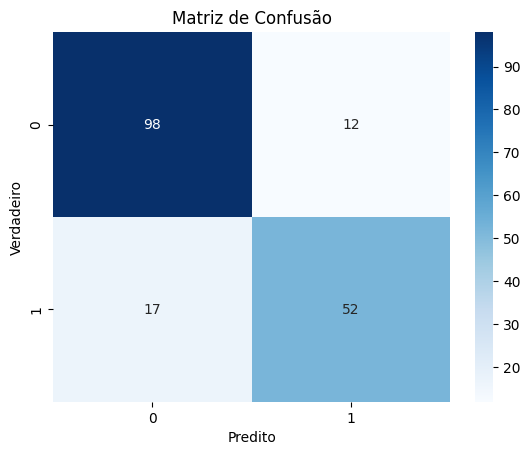

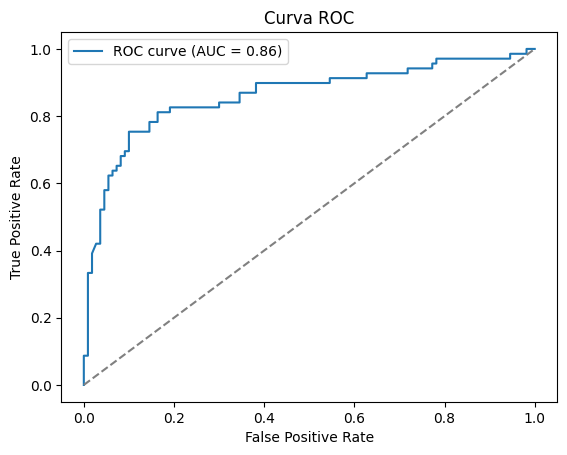

In [19]:
# --------------------------
# GRÁFICOS DE AVALIAÇÃO
# --------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Matriz de confusão heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()


IMPORTÂNCIA DAS VARIÁVEIS

Top 15 features por impacto absoluto:
         Feature      Coef
8      Title_Mr -2.008069
9     Title_Mrs  1.410412
14  CabinDeck_E  1.082985
13  CabinDeck_D  0.963201
18  CabinDeck_U -0.694487
16  CabinDeck_G -0.612392
10   Title_Rare -0.589115
7    Title_Miss  0.587769
20     Pclass_3 -0.571671
3      Fare_log  0.536566
1         SibSp -0.513763
0           Age -0.501118
2         Parch -0.364783
15  CabinDeck_F  0.336294
6    Embarked_S -0.318736


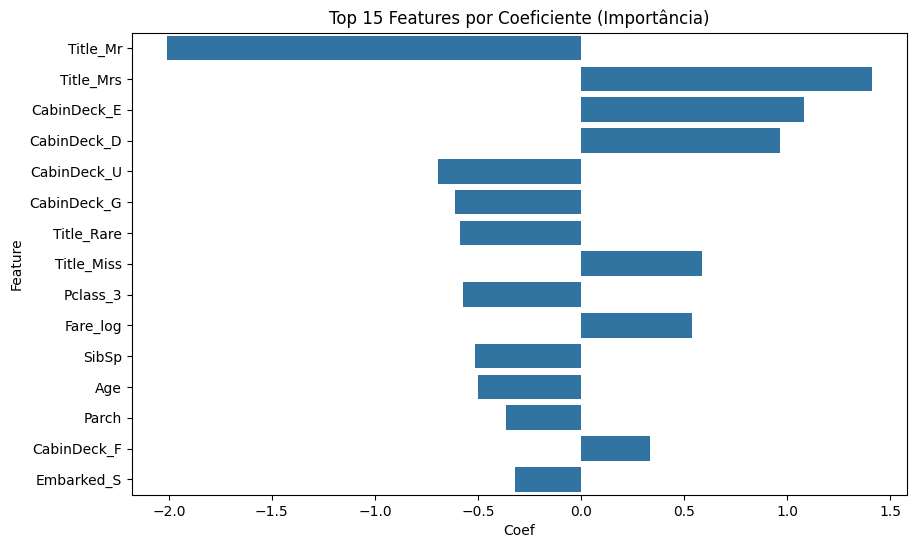

In [21]:
# --------------------------
# IMPORTÂNCIA DAS VARIÁVEIS
# --------------------------
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coef': model.coef_.flatten()
}).sort_values(by='Coef', key=lambda x: x.abs(), ascending=False)

print("Top 15 features por impacto absoluto:\n", coef_df.head(15))

# Gráfico de coeficientes
plt.figure(figsize=(10,6))
sns.barplot(x='Coef', y='Feature', data=coef_df.head(15))
plt.title('Top 15 Features por Coeficiente (Importância)')
plt.show()


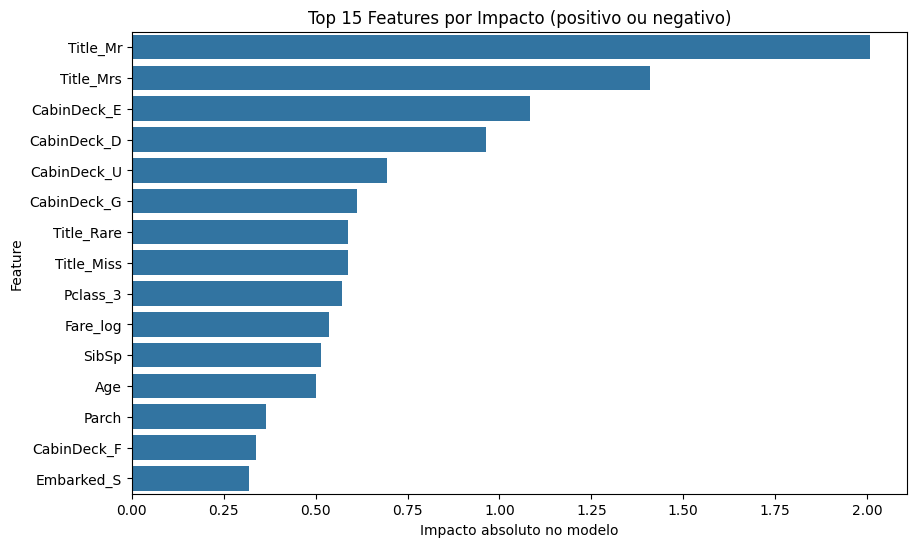

In [29]:
coef_df['abs_coef'] = coef_df['Coef'].abs()
top_coef = coef_df.sort_values(by='abs_coef', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x='abs_coef', y='Feature', data=top_coef )
plt.xlabel('Impacto absoluto no modelo')
plt.title('Top 15 Features por Impacto (positivo ou negativo)')
plt.show()
